# Exercise 3 - CNNs, ResNets and LR-Scheduling

## General information
* Deep Learning – Winter term 2020/21
* Instructor: Alexander Ecker
* Tutors: Max Burg, Laura Pede
* Teaching assistants: Clara Holzhüter, Pronaya Prosun Das
* Due date: **Tue, 15. Dec 20, 2:15pm**

### Time required to solve this exercise sheet
**As you will train a large number of models on this exercise sheet, model training will require an increased amount of time. So we recommend to start working on this sheet early.**

### Topics

In this exercise sheet, you will:
- work again with CIFAR-10
- implement a 1-layer CNN
- compare MLP and CNN
- vary architecture to improve model performance
- implement a ResNet for CIFAR-10
- learn about learning rate scheduling
- [learn about transfer learning]

*We are looking forward to seeing your solutions! Have fun!*

### Important submission instructions

- **You need to answer all questions in written form!**
- When you're done, download the notebook and rename it to \<surname1\>_\<surname2\>_\<surname3\>.ipynb
- Only submit the ipynb file, no other file is required
- Submit only once
- The deadline is strict
- You are required to present your solution in the tutorial; submission of the notebook alone is not sufficient
- Do not change the cells which are marked as "Do not change", similarly write your solution into the marked cells.

### Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau, ExponentialLR, StepLR
import torchvision
from torchvision import datasets, transforms, models
import fastprogress
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import time



## 1. Setup

You can use the functions to grab the data, split the sets and create the dataloaders, etc. given to you at exercise sheet 2.

It is good practice to store functions that are constantly needed again in a separate file such that instead of copy-pasting the cells into each exercise notebook, you can use the python file containing the functions and import it in the notebooks.

If you work with Colab (which is recommended) you have to mount the drive first and create a path to your python module.

#### **TODO**
Create a file named 'utils.py' and import it here. You can import any package necessary.

In [2]:
# TODO import utils.py
#mount drive
from google.colab import drive
drive.mount('/content/drive')

#update sys path
import sys
sys.path.append('/content/drive/My Drive/Colab Notebooks')

#import module
from utils import *

Mounted at /content/drive


## 2. Load dataset, create dataloader, etc.

#### **TODO**
Call the functions of 'utils.py' to instantiate the train-, test- and validation datasets along with their dataloaders.

In [3]:
# TODO define device
device = get_device()

cuda available: True ; cudnn available: True ; num devices: 1
Using device Tesla P4


In [4]:
data_dir = 'data'
batch_size = 256

# TODO grab data, generate split, init data loaders
# load data and split into train and test
trainset, testset, dataset_mean, dataset_std = grab_data('./data', num_cpus=1)

#split train and val
trainset, valset = generate_train_val_data_split(trainset, split_seed=42, val_frac=0.2)

#init data loaders
trainloader, valloader, testloader = init_data_loaders(trainset, valset, testset, batch_size=batch_size, num_cpus=1)

Extracting ./data/cifar-10-python.tar.gz to ./data

Files already downloaded and verified
Files already downloaded and verified


#### **TODO** 
Define the loss function. We use the cross entropy loss again.

In [5]:
# TODO define loss function
loss_function = nn.CrossEntropyLoss()

## 3. Simple 1-layer CNN model

### **TODO**
- Define the model.

The first step to training a model is defining its architecture. 
Define a sequential model with following structure:
*   Convolutional layer with 32 filters, kernel size of 5*5 and stride of 1.
*   Max Pooling layer with kernel size of 2*2 and default stride.
*   ReLU Activation Layers.
*   Linear layer with output of 512.
*   ReLU Activation Layers.
*   A linear layer with output of 10.

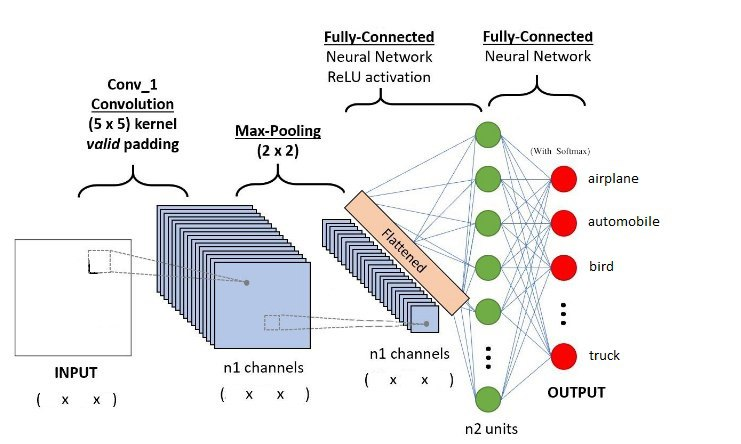

#### **Questions**

- What are the input dimensions?
- What are the dimensions of the feature maps?
- What are the dimensions after pooling?
- What are the values for n1 and n2?
- What is the number of parameters for conv_1?

**Your answers here**


- 32x32X3
- 28x28
- 14x14
- n1 == n2 == 32
- 5x5x3x28 == 2100



In [6]:
# TODO define model
class CONV(nn.Module):
    """Multi layer perceptron torch model."""
    def __init__(self, img_width, num_in_channels=3, num_classes=10):
        """Initialize model.

        Args:
            img_width (int): Width of images
            num_in_channels (int): Number of input channels of images
            num_classes (int): Number of classes to predict
            num_hidden_units (int, optional): Number of hidden units per layer. 
                Defaults to 30.
            num_hidden_layers (int, optional): Number of hidden layers. Total
                number of layers will be num_hidden_layers + 2. Defaults to 1.
            act_fn (nn activation function, optional): Activation function
                to use after the first and all the hidden layers. If None, use
                nn.ReLU(). Defaults to None.
        """
        ####################
        ## YOUR CODE HERE ##
        ####################
        super().__init__()
        self.conv1 = nn.Conv2d(num_in_channels, 32, kernel_size=5, stride=1)
        self.max1 = nn.MaxPool2d(2)
        self.act1 = nn.ReLU()
        #shape: 256, 32, 14, 14
        #self.fc1 = nn.Linear(256* 32 * 14 * 14, 512)
        self.fc1 = nn.Linear(32 * 14 * 14, 512)
        self.act2 = nn.ReLU()
        self.fc2 = nn.Linear(512, num_classes)

    
    def forward(self, x):
        """Compute model predictions.

        Args:
            x (torch.Tensor, shape (batchsize, num_channels, x, y)): Tensor of
                batch of input images

        Returns:
            torch.Tensor, shape (batchsize, num_classes): Tensor of model
                predictions
        """
        out = self.conv1(x)
        out = self.max1(out)
        #out = out.view(-1, 256*32*14*14)
        out = out.view(-1, 32*14*14)
        out = self.act1(out)        
        out = self.fc1(out)
        out = self.act2(out)
        out = self.fc2(out)
        return out

#### **TODO**

- Train the model for 10 epochs. Use a learning rate of 0.001.
- Plot the results of accuracy and loss as you did in exercise sheet 2.

Finished training after 117 seconds.


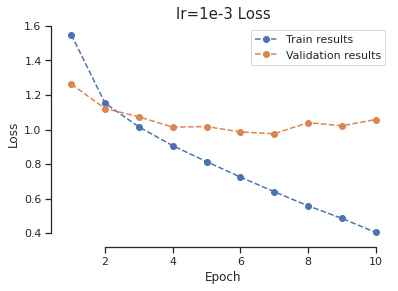

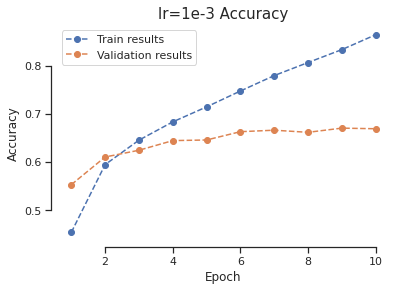

In [8]:
# TODO train and plot
lr = 1e-3
num_epochs = 10

model = CONV(32)
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

train_losses, val_losses, train_accs, val_accs, confusion_matrix = run_training(model, optimizer, loss_function, device, num_epochs, trainloader, valloader)
plot("lr=1e-3 Loss", "Loss", train_losses, val_losses, yscale='linear')
plot("lr=1e-3 Accuracy", "Accuracy", train_accs, val_accs, yscale='linear')

#### **TODO**
Compare results to MLP. What can you observe?

**Your answers here**

The model is more accurate than the best MLP model we found even before any hyperparameter tuning.

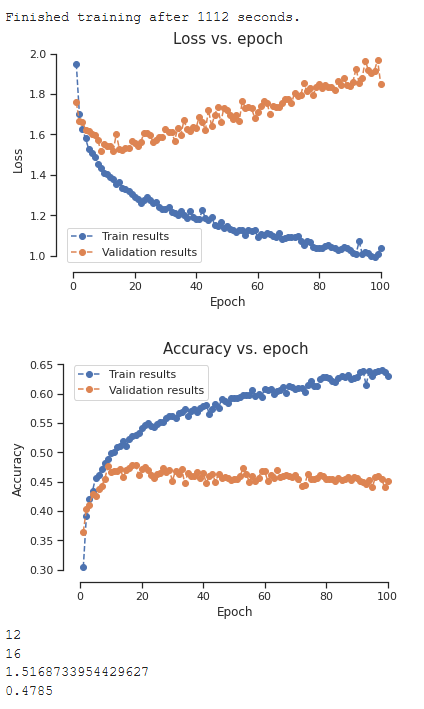

#### **TODO** 
Train longer (ca. 60 epochs), plot again.

Finished training after 703 seconds.


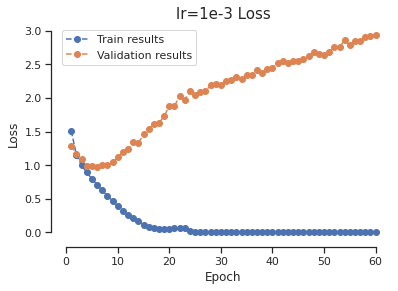

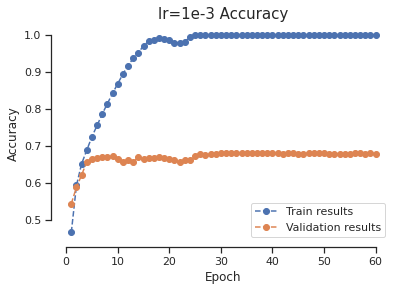

In [ ]:
# TODO train and plot
num_epochs = 60

model = CONV(32)
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

train_losses, val_losses, train_accs, val_accs, confusion_matrix = run_training(model, optimizer, loss_function, device, num_epochs, trainloader, valloader)
plot("lr=1e-3 Loss", "Loss", train_losses, val_losses, yscale='linear')
plot("lr=1e-3 Accuracy", "Accuracy", train_accs, val_accs, yscale='linear')

#### **Questions**
- Why is that not an optimal model?
- What could be improved?

**Your answers here**

#### **Questions**
- The model cannot see enough interesting features & the receptive field size of the convolutional layers was small
- Increase the depth of the neural network

## 4. CNN model with more convolutional layers

#### **TODO**
Define the architecture displayed in the graphic.

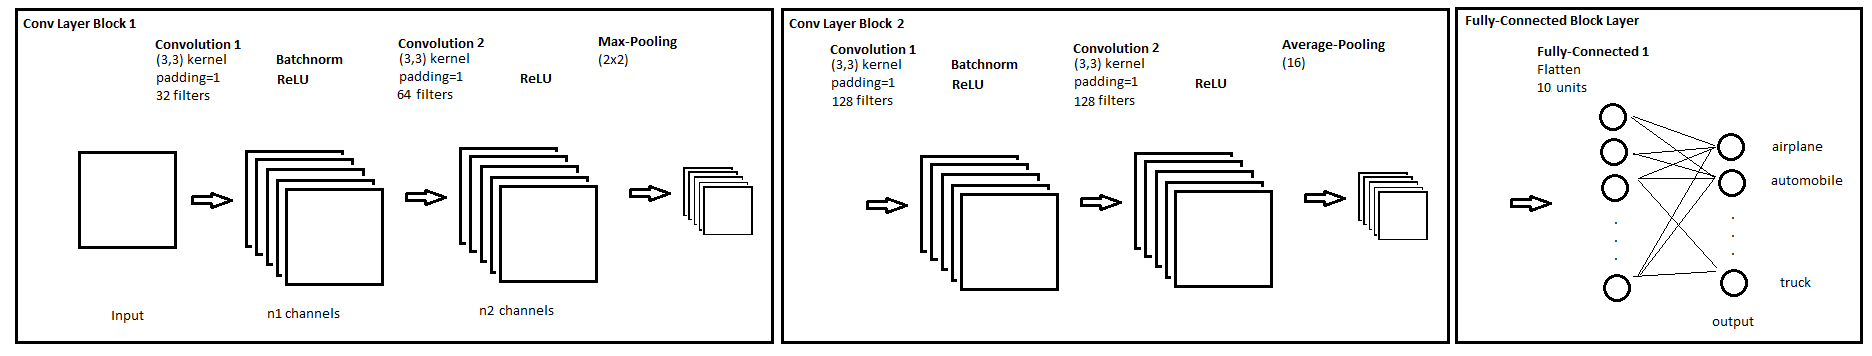

#### **Questions**

- Padding is used in the convolutional layers. What does that mean, which variants exist and how does it influence the dimensions of the feature maps?
- What does padding=1 mean in the case of the network displayed above?
- What are the dimensions of the feature maps after the 1. conv layer?
- What are the dimensions of the feature maps after the 2. conv layer?
- What ist the receptive field size after the first two convolutions?
- What is the value for the in_features for the fully-connected layer?
- What is the number of parameters of *Conv Layer block 1*?

**Your answers here**


*   With every convolution operation the image shrinks and the pixels on the corners and the edges are used much less than those in the middle. In general, pixels in the middle are used more often than pixels on corners and edges. Consequently, the information on the borders of images are not preserved as well as the information in the middle.To overcome these problems, padding is used. Padding is simply a process of adding layers of zeros to our input images.
Variants: Valid Padding, It implies no padding at all. The input image is left in its valid/unaltered shape
Same Padding : In this case, we add ‘p’ padding layers such that the output image has the same dimensions as the input image

* p = number of layers of zeros added to the border of the image, then our (n x n) image becomes (n + 2p) x (n + 2p) image after padding. 

* 32x32

* 32x32

* 5x5

* 128

* 3x3x3x32 + 3x3x32x64 = 19296

In [7]:
#TODO define model 2
class CONV2(nn.Module):
    """Multi layer perceptron torch model."""
    def __init__(self, img_width, num_in_channels=3, num_classes=10):

        super().__init__()

        #Block 1
        self.conv1 = nn.Conv2d(num_in_channels, 32, kernel_size=3, padding=1)
        self.conv1_batchnorm = nn.BatchNorm2d(num_features=32)
        self.act1 = nn.ReLU()
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.act2 = nn.ReLU()
        self.max1 = nn.MaxPool2d(2)

        #Block 2
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv3_batchnorm = nn.BatchNorm2d(num_features=128)
        self.act3 = nn.ReLU()
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.act4 = nn.ReLU()
        self.avg1 = nn.AvgPool2d(16)

        #Fully connected block layer
        self.fc1 = nn.Linear(128, 10)
    
    def forward(self, x):
        #Forwar block 1
        out = self.conv1(x)
        out = self.conv1_batchnorm(out)
        out = self.act1(out)
        out = self.conv2(out)
        out = self.act2(out)
        out = self.max1(out)

        #Forward block 2
        out = self.conv3(out)
        out = self.conv3_batchnorm(out)
        out = self.act3(out)
        out = self.conv4(out)
        out = self.act4(out)
        out = self.avg1(out)

        #Forward fully connected block
        out = out.view(-1, 128)
        out = self.fc1(out)
  
        return out

#### **TODO** 

- train the new net (30 epochs, lr=0.1), plot the results, and compare the results to the 1-layer CNN
- explain why you observe these results

Finished training after 413 seconds.


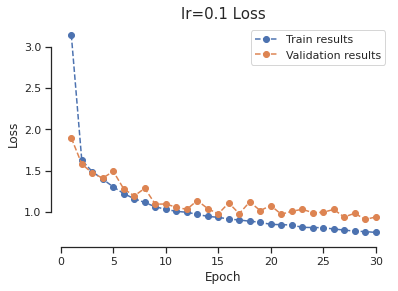

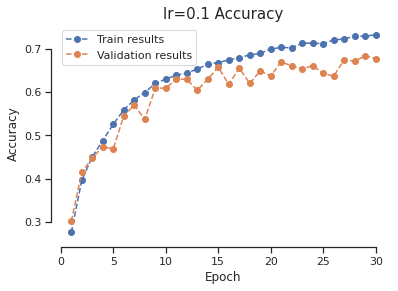

In [ ]:
# TODO train and plot128,
num_epochs = 30
lr = 0.1

model2 = CONV2(32)
model2 = model2.to(device)

optimizer = torch.optim.Adam(model2.parameters(), lr=lr)

train_losses, val_losses, train_accs, val_accs, confusion_matrix = run_training(model2, optimizer, loss_function, device, num_epochs, trainloader, valloader)
plot("lr=0.1 Loss", "Loss", train_losses, val_losses, yscale='linear')
plot("lr=0.1 Accuracy", "Accuracy", train_accs, val_accs, yscale='linear')

**Comparison**
This network does not perform better than the network with 1 convolutional layer.

**Explanation**
The network is still not deep enough.

## 5. ResNet architecture

"*Deeper neural networks are more difficult to train.  We present a residual learning framework to ease the training of networks that are substantially deeper than those used previously.*" [ https://arxiv.org/pdf/1512.03385.pdf]

That was the intention of He et al. to develop residual networks.

A ResNet is built of blocks which are called the *Residual Blocks*. 
A residual block uses *skip connections* - shortCuts — to jump over some layers to skip some activations.
The Resnet skips connections via addition.

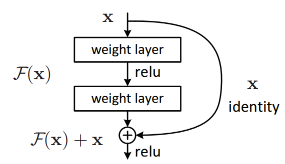

#### **Questions**
- Which problems do using skip connections solve?
- Why is a residual network called residual? 
- When is the advantage of ResNets over 'normal' CNNs most visible?

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Your answers here**

* Skip connections provide a shorter path through a deep network. This makes it possible to train a deep network in smaller steps, which helps with optimisation.

* A residual of a function F is F(x) - x. Resnets add shortcuts and train future layers with F(x) - x instead of F(x)

* The advantage is most visisble when the network is very deep, as deep networks are harder to train.

#### **TODO**
- write a class **ResidualBlock(nn.Module)** where you define the blocks used in the ResNet
- write a class **ResNet(nn.Module)** where you define the model; the class contains the following methods:
    - init
    - make_layer
    - forward
- train the model
- plot results

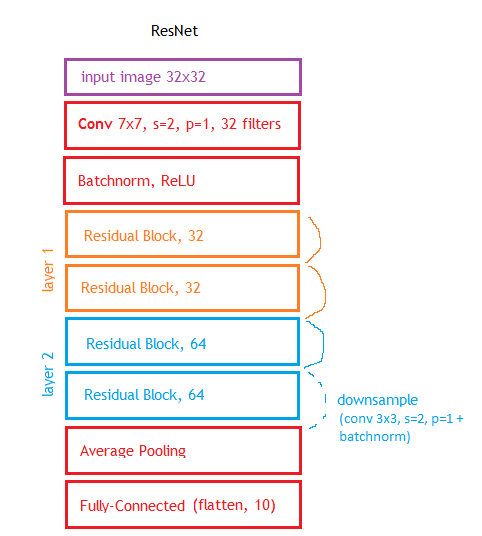
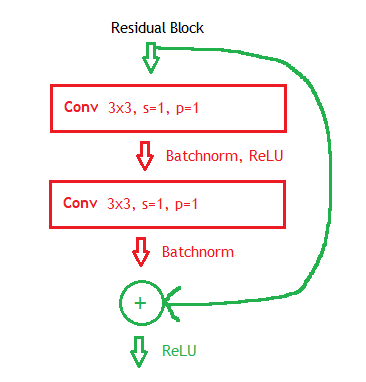

In [9]:
def conv3x3(in_channels, out_channels, stride=1):
    return nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)

class ResidualBlock(nn.Module):
    '''
        Conv--> Batchnorm-->ReLu-->Conv-->Batchnorm--> 
        Only downsample if needed
    '''
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        # TODO
        self.conv1 = conv3x3(in_channels, out_channels, stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(out_channels, out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample
        
        
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

In [10]:
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(ResNet, self).__init__()
        #TODO
        self.in_channels = 32

        self.conv = nn.Conv2d(3, 32, 7, stride= 2)
        self.conv_batchnorm = nn.BatchNorm2d(32)
        self.act1 = nn.ReLU()
        self.layer1 = self.make_layer(block, 32, layers[0])
        self.layer2 = self.make_layer(block, 64, layers[1])
        self.avg_pool = nn.AvgPool2d(8)
        self.fc = nn.Linear(64, num_classes)
        
    def make_layer(self, block, out_channels, blocks, stride=1, padding=0):
        # TODO
        downsample = None
        if (stride != 1) or (self.in_channels != out_channels):
            downsample = nn.Sequential(
                conv3x3(self.in_channels, out_channels, stride=stride),
                nn.BatchNorm2d(out_channels))
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for i in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)
    
    def forward(self, x):
        #TODO
        out = self.conv(x)
        out = self.conv_batchnorm(out)
        out = self.act1(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out
        

Finished training after 629 seconds.


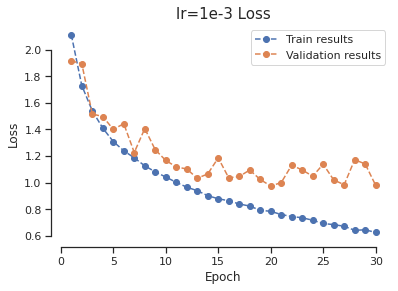

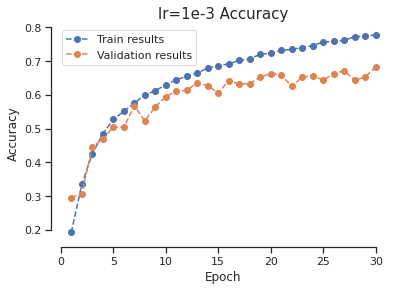

In [ ]:
# TODO train and plot
num_epochs = 30
lr = 0.1

model3 = ResNet(ResidualBlock, [2, 2]).to(device)

optimizer = torch.optim.Adam(model3.parameters(), lr=lr)

train_losses, val_losses, train_accs, val_accs, confusion_matrix = run_training(model3, optimizer, loss_function, device, num_epochs, trainloader, valloader)
plot("lr=1e-3 Loss", "Loss", train_losses, val_losses, yscale='linear')
plot("lr=1e-3 Accuracy", "Accuracy", train_accs, val_accs, yscale='linear')

#### **Questions**
- Does the performance increase compared to the CNNs you trained before? Why/Why not?
- Compare the runtime of CNN and ResNet.



**Your answers here**

* The performance was almost identical to the previous networks. This is because the neetwork is not deep enough for ResNet to be very helpful.

* CNN: 413 seconds. ResNet: 377 seconds. The ResNet is slighlty faster.

## 6. Explore Learning Rate Scheduling

Learning rate scheduling is a mechanism to adjust the learning rate.

*torch.optim.lr_scheduler* provides several methods based on the number of epochs. Learning rate scheduling should be applied after optimizer’s update.

#### **TODO**
- change run_training and extend to use scheduler for learning rate
- use StepLR (https://pytorch.org/docs/stable/optim.html), use the ResNet, train for 10 epochs. Start with a learning rate of 0.1.


#### **Questions**

- Try step size 1, gamma 0.1
    - How does it change the learning rate?
    - what do you observe regarding performance?
- Try step size 1, gamma 0.9, what do you observe?
    - How does it change the learning rate?
    - what do you observe regarding performance?
- What can you conclude of this experiment regarding the synergy of step size and gamma to get a good schedule?

**Your answers here**

In [11]:
# TODO change run_training (you can copy the code from utils.py here and create a new method here 
# or just change/create a new method it in the python file)

def run_training(model, optimizer, loss_function, device, num_epochs, 
                 train_dataloader, val_dataloader, early_stopper=None,
                 verbose=False, scheduler=None):
    start_time = time.time()
    master_bar = fastprogress.master_bar(range(num_epochs))
    train_losses, val_losses, train_accs, val_accs = [],[],[],[]

    for epoch in master_bar:
        # Train the model
        epoch_train_loss, epoch_train_acc = train(train_dataloader, optimizer, model, 
                                                  loss_function, device, master_bar)
        # Validate the model
        epoch_val_loss, epoch_val_acc, confusion_matrix = validate(val_dataloader, 
                                                                   model, loss_function, 
                                                                   device, master_bar)

        # Save loss and acc for plotting
        train_losses.append(epoch_train_loss)
        val_losses.append(epoch_val_loss)
        train_accs.append(epoch_train_acc)
        val_accs.append(epoch_val_acc)
        
        if verbose:
            master_bar.write(f'Train loss: {epoch_train_loss:.2f}, val loss: {epoch_val_loss:.2f}, train acc: {epoch_train_acc:.3f}, val acc {epoch_val_acc:.3f}')
            
        if early_stopper:
            early_stopper.update(epoch_val_acc, model)
            if early_stopper.counter == 0:
                early_stopper.save_checkpoint(model, epoch_val_acc)
            if early_stopper.early_stop:
                early_stopper.load_checkpoint(model)
                break

        if scheduler:
            scheduler.step()

            
    time_elapsed = np.round(time.time() - start_time, 0).astype(int)
    print(f'Finished training after {time_elapsed} seconds.')
    return train_losses, val_losses, train_accs, val_accs, confusion_matrix



Finished training after 128 seconds.


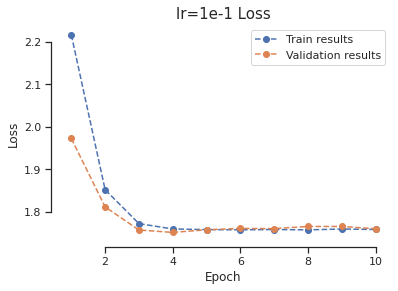

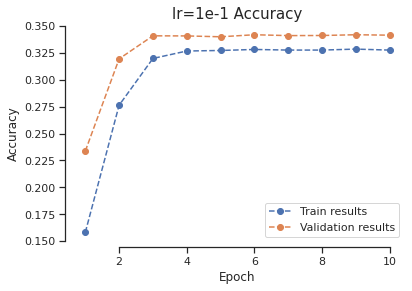

In [23]:
# TODO train and plot with step size 1, gamma 0.1

lr = 1e-1
num_epochs = 10

model3 = ResNet(ResidualBlock, [2, 2]).to(device)

optimizer = torch.optim.Adam(model3.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)

train_losses, val_losses, train_accs, val_accs, confusion_matrix = run_training(model3, optimizer, loss_function, device, num_epochs, trainloader, valloader, scheduler=scheduler)
plot("lr=1e-1 Loss", "Loss", train_losses, val_losses, yscale='linear')
plot("lr=1e-1 Accuracy", "Accuracy", train_accs, val_accs, yscale='linear')




*   The learning rate decayed by 0.1 after every epoch
*   The performance is worse. The decay is too fast, and we see that the model stops improving after about 4 epochs because the learning rate is too low.



Finished training after 128 seconds.


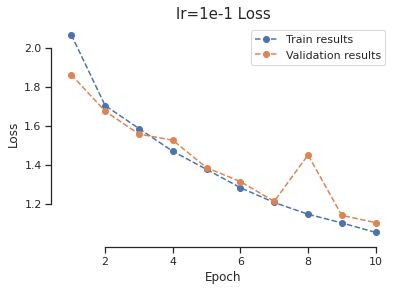

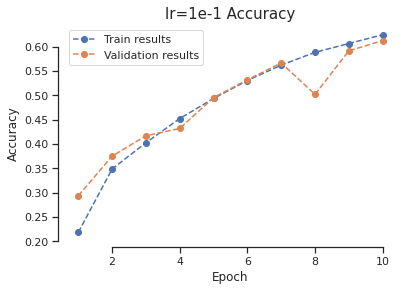

In [25]:
# TODO train and plot with step size 1, gamma 0.9

model4 = ResNet(ResidualBlock, [2, 2]).to(device)

optimizer = torch.optim.Adam(model4.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)

train_losses, val_losses, train_accs, val_accs, confusion_matrix = run_training(model4, optimizer, loss_function, device, num_epochs, trainloader, valloader, scheduler=scheduler)
plot("lr=1e-1 Loss", "Loss", train_losses, val_losses, yscale='linear')
plot("lr=1e-1 Accuracy", "Accuracy", train_accs, val_accs, yscale='linear')


*   The learning rate decayed by 0.9 after every epoch
*   The performance of the model is good. It is better than the previous model after 10 epochs.

*   We can conclude that the learning rate needs to be tuned to the model, if it decays too quickly, then the model cannot be trained.

#### **TODO** 

Use the learning rate schedule as described in the ResNet paper (https://arxiv.org/pdf/1512.03385.pdf). Train for 30 epochs.

#### **Questions**
- Does it improve performance?
- What can you observe in the plots?

**Your answers here**

Finished training after 425 seconds.


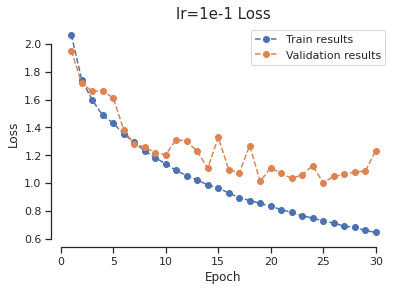

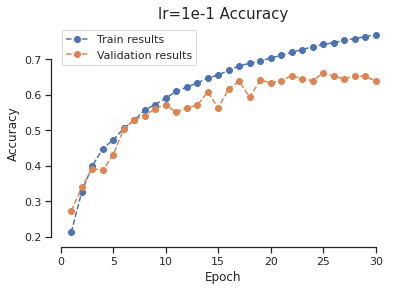

In [16]:
# TODO train and plot with scheduling, optimizer, lr as in the paper.

num_epochs = 30

model = ResNet(ResidualBlock, [2, 2]).to(device)
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[15, 22], gamma=0.1, last_epoch=-1, verbose=False)

train_losses, val_losses, train_accs, val_accs, confusion_matrix = run_training(model, optimizer, loss_function, device, num_epochs, trainloader, valloader)
plot("lr=1e-1 Loss", "Loss", train_losses, val_losses, yscale='linear')
plot("lr=1e-1 Accuracy", "Accuracy", train_accs, val_accs, yscale='linear')



*   This did not improve the performance.
*   There are no noticeable jumps at the milestones.



## [7. Optional LR-Scheduling]

#### **TODO**
- try two more scheduler: ExponentialLR and ReduceLROnPlateau 
- vary the parameters, which work best?
- does it improve performance compared to no scheduler?
- does it improve performance compared to StepLR?

**Your answers here**

In [ ]:
# TODO train and plot

## [8. Optional Transfer Learning]

### **TODO**

- load a pretrained ResNet from torchvision
- freeze the parameters so that the gradients are not computed
- replace the last fully-connected layer
- fine-tune the model
- plot the results again and compare to approaches before
    - is a better performance reached? why/why not?
    - does it take more/less time to fine-tune compared to train a resnet?

**Your answers here**

In [ ]:
# TODO do transfer learning with resnet on cifar10